<a href="https://colab.research.google.com/github/leocaricchio/ProjetoPIMAG/blob/main/PROJETOFINALPIMAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processando detecção de objetos...


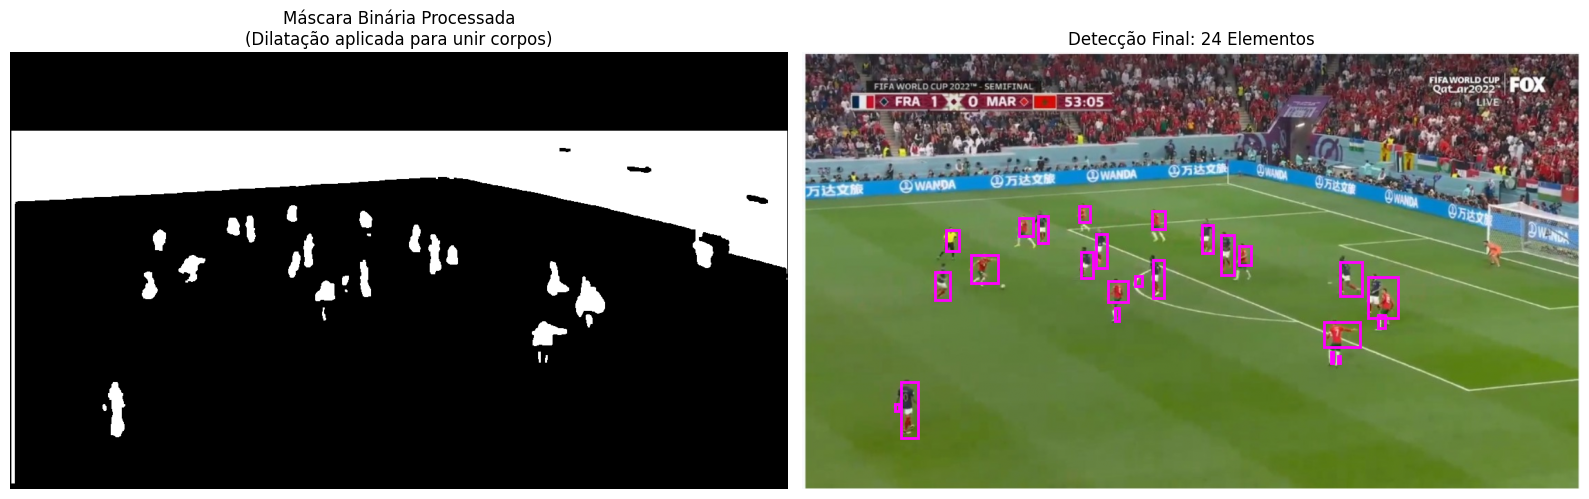

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from skimage.color import rgb2hsv # Permitido conforme slide 4 do PDF 'cores.pdf'

# ==============================================================================
# 1. FUNÇÕES MANUAIS (Morfologia e Detecção - Sem OpenCV)
# ==============================================================================

def manual_erosion(binary_img, kernel_size=3):
    """
    Erosão: O pixel central só fica BRANCO se TODOS os vizinhos forem brancos.
    Serve para remover ruídos pequenos.
    """
    rows, cols = binary_img.shape
    pad = kernel_size // 2
    padded = np.pad(binary_img, pad, mode='constant', constant_values=0)
    output = np.zeros_like(binary_img)

    for i in range(rows):
        for j in range(cols):
            # Recorte da vizinhança
            region = padded[i:i+kernel_size, j:j+kernel_size]
            if np.all(region): # Lógica AND
                output[i, j] = 1
    return output

def manual_dilation(binary_img, kernel_size=3):
    """
    Dilatação: O pixel central fica BRANCO se PELO MENOS UM vizinho for branco.
    Serve para conectar objetos quebrados e preencher buracos.
    """
    rows, cols = binary_img.shape
    pad = kernel_size // 2
    padded = np.pad(binary_img, pad, mode='constant', constant_values=0)
    output = np.zeros_like(binary_img)

    for i in range(rows):
        for j in range(cols):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            if np.any(region): # Lógica OR
                output[i, j] = 1
    return output

def encontrar_objetos_manualmente(mask, min_area=20, max_area=6000):
    """
    Algoritmo Flood Fill para rotular componentes conexos.
    Substitui cv2.findContours.
    """
    rows, cols = mask.shape
    visited = np.zeros_like(mask, dtype=bool)
    objetos = [] # Lista de tuplas (y, x, h, w)

    # Vizinhança-4 é mais rápida e suficiente para este caso
    vizinhos = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    for y in range(rows):
        for x in range(cols):
            if mask[y, x] and not visited[y, x]:
                # Inicia novo objeto
                min_y, max_y = y, y
                min_x, max_x = x, x

                stack = [(y, x)]
                visited[y, x] = True
                pixel_count = 0

                while stack:
                    cy, cx = stack.pop()
                    pixel_count += 1

                    # Atualiza limites (Bounding Box)
                    if cy < min_y: min_y = cy
                    if cy > max_y: max_y = cy
                    if cx < min_x: min_x = cx
                    if cx > max_x: max_x = cx

                    for dy, dx in vizinhos:
                        ny, nx = cy + dy, cx + dx
                        if 0 <= ny < rows and 0 <= nx < cols:
                            if mask[ny, nx] and not visited[ny, nx]:
                                visited[ny, nx] = True
                                stack.append((ny, nx))

                # Filtra ruídos muito pequenos ou muito grandes
                if pixel_count > min_area and pixel_count < max_area:
                    h = max_y - min_y + 1
                    w = max_x - min_x + 1
                    objetos.append((min_y, min_x, h, w))

    return objetos

# ==============================================================================
# 2. FLUXO PRINCIPAL DO PROGRAMA
# ==============================================================================

# A. Carregar Imagem
arquivo_imagem = '/content/IMG-20260209-WA0013.jpg' # Seu arquivo atual
try:
    img_original = mpimg.imread(arquivo_imagem)
except FileNotFoundError:
    print("Erro: Imagem não encontrada. Verifique o nome do arquivo.")
    # Cria imagem preta para não quebrar o código na execução
    img_original = np.zeros((400, 600, 3))

# Remove canal alpha (PNG transparente) se existir
if img_original.shape[2] == 4:
    img_original = img_original[:, :, :3]

# Normaliza para 0.0 - 1.0
if img_original.max() > 1:
    img_original = img_original / 255.0

# B. Segmentação HSV (Baseado no PDF 'cores.pdf')
img_hsv = rgb2hsv(img_original)
H = img_hsv[:, :, 0]
S = img_hsv[:, :, 1]
V = img_hsv[:, :, 2]

# Definição do Verde (Campo)
# Matiz (H): Verde fica entre 0.20 e 0.45
# Saturação (S): > 0.2 (Grama tem cor, não é cinza)
# Valor (V): > 0.2 (Não é breu total)
mask_campo = (H > 0.20) & (H < 0.45) & (S > 0.2) & (V > 0.2)

# O objeto é o inverso do campo
mask_objetos = ~mask_campo

# C. Ajuste de ROI (Region of Interest)
rows, cols = mask_objetos.shape
# Cortamos apenas 18% do topo para remover torcida, mas manter o travessão/goleiro
corte_torcida = int(rows * 0.18)
mask_objetos[0:corte_torcida, :] = 0
mask_objetos[-10:, :] = 0 # Remove borda inferior suja

# D. Morfologia Matemática (Correção de Fragmentação)
# 1. Erosão Leve: Remove pontinhos brancos isolados (ruído)
mask_limpa = manual_erosion(mask_objetos, kernel_size=2)

# 2. Dilatação Forte: "Cola" camisa no calção e junta partes separadas
mask_fechada = manual_dilation(mask_limpa, kernel_size=6)

# 3. Erosão Média: Recupera a forma original do corpo (sem isso eles ficam "gordos")
mask_final = manual_erosion(mask_fechada, kernel_size=4)

# E. Detecção e Classificação
print("Processando detecção de objetos...")
objetos_brutos = encontrar_objetos_manualmente(mask_final, min_area=35, max_area=5000)

objetos_finais = []

for (y, x, h, w) in objetos_brutos:
    aspect_ratio = h / float(w) # Razão Altura / Largura

    # Critérios de Aceitação:
    # 1. Verticalidade: Jogadores são mais altos que largos.
    #    Usamos > 0.6 para aceitar goleiros agachados ou jogadores correndo.
    eh_vertical = aspect_ratio > 0.6

    # 2. Bola: É pequena e "quadrada" (ratio perto de 1)
    eh_bola = (aspect_ratio > 0.8 and aspect_ratio < 1.2) and (h < rows * 0.03)

    # 3. Filtro de Linhas: Linhas do campo são muito largas horizontalmente.
    # Se a largura for maior que 8% da imagem, descartamos.
    nao_eh_linha_larga = w < (cols * 0.08)

    if (eh_vertical or eh_bola) and nao_eh_linha_larga:
        objetos_finais.append((y, x, h, w))

# ==============================================================================
# 3. VISUALIZAÇÃO DOS RESULTADOS
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Esquerda: Máscara Binária Processada
ax[0].imshow(mask_final, cmap='gray')
ax[0].set_title("Máscara Binária Processada\n(Dilatação aplicada para unir corpos)")
ax[0].axis('off')

# Direita: Imagem Final com Bounding Boxes
ax[1].imshow(img_original)
ax[1].set_title(f"Detecção Final: {len(objetos_finais)} Elementos")

for (y, x, h, w) in objetos_finais:
    # Retângulo (Magenta para destaque no verde)
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='#FF00FF', facecolor='none')
    ax[1].add_patch(rect)

ax[1].axis('off')

plt.tight_layout()
plt.show()

/content/IMG-20260209-WA0013.jpg